### 코더의 소회 : 
날씨 : 오늘의 학습 < >했습니다. [☀️⛅☁️🌧️🌩️⛈️]
- 배운점 : 
- 아쉬운점 :  
- 느낀점 :

(참고 : https://github.com/Annyong2/AIFFEL_quest_rs/tree/master/GoingDeeper/Gdr01)

### 전체 코드 실행 플로우 (목차):
**Step 01. 불러오기 & 구경하기**    
      - 불러오기: 라이브러리(SentencePiece,konlpy) / 데이터셋(네이버 영화리뷰 감정 분석 데이터)   
      - 데이터 구경하기(pandas, tensorflow)  
**Step 02. 데이터 전처리(tensorflow)**   
      - 기본 전처리(기호,빈 줄 제거 등)   
**Step 03. SentencePiece 모델 학습 및 Tokenizer 함수 작성**    
**Step 04. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기**   
      - SentencePiece 모델을 사용하여 토크나이저 생성    
      - 네이버 영화리뷰 감정 분석 모델 구축 및 학습  
**Step 05. KoNLPy 형태소 분석기와의 성능 비교 (SentencePiece VS. Mecab)**

---

# Step 01. 불러오기 & 구경하기 & 전처리
---

## 1-1. 라이브러리 불러오기(SentencePiece, konlpy 등)

In [1]:
import os
import urllib.request

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import sentencepiece as spm # SentencePiece 불러오기
import konlpy               # konlpy 불러오기(Mecab, kkma, Okt)
from konlpy.tag import Mecab
from konlpy.tag import Okt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

 
%matplotlib inline

## 1-2. 데이터셋 불러오기

In [2]:
def download_dataset(url, dataset_path):
    # 데이터셋 다운로드
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    
    train_url = url + '/ratings_train.txt'
    test_url = url + '/ratings_test.txt'

    train_data_path = os.path.join(dataset_path, 'ratings_train.txt')
    test_data_path = os.path.join(dataset_path, 'ratings_test.txt')

    urllib.request.urlretrieve(train_url, train_data_path)
    urllib.request.urlretrieve(test_url, test_data_path)

    print("데이터셋이 성공적으로 다운로드되었습니다.")

In [3]:
# NSMC 데이터셋 다운로드
url = "https://github.com/e9t/nsmc/raw/master"
dataset_path = os.getenv('HOME') + '/aiffel/sp_tokenizer/data'

download_dataset(url, dataset_path)

데이터셋이 성공적으로 다운로드되었습니다.


In [4]:
# 데이터 파일 경로 설정
train_data_path = os.path.join(dataset_path, 'ratings_train.txt')
test_data_path = os.path.join(dataset_path, 'ratings_test.txt')

## 데이터셋 구경하기 : Pandas

In [5]:
train_df = pd.read_csv(train_data_path, sep='\t')
test_df  = pd.read_csv(test_data_path, sep='\t')

### [PD]Train, Test 샘플확인

In [6]:
print('전체 샘플수 :', (len(train_df)))
train_df.head(5)

전체 샘플수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
print('전체 샘플수 :', (len(test_df)))
test_df.head(5)

전체 샘플수 : 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### [PD]Train, Test 결측치 확인

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [9]:
train_df[train_df['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [11]:
test_df[test_df['document'].isnull()]

,id,document,label
5746,402110,NaN,1
7899,5026896,NaN,0
27097,511097,NaN,1


- **전체샘플수**  
    train_df -> 150000    
    test_df  ->   50000    


- **결측치**  
    train_df['document'] : 5건  
    test_df['document']  : 3건  
    
    
- **document(리뷰)형태 확인 완료**

## 데이터셋 구경하기 : Tensorflow

In [12]:
path_to_file = train_data_path

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw)-1) # 헤더 빼주기

# 첫 5줄 출력 (헤더 포함)
print("Example:")
for sen in raw[0:5]:
    print(">>", sen)

Data Size: 150000
Example:
>> id	document	label
>> 9976970	아 더빙.. 진짜 짜증나네요 목소리	0
>> 3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
>> 10265843	너무재밓었다그래서보는것을추천한다	0
>> 9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0


### 문장길이 : document만 따로 뽑아 보기

In [13]:
# tab제거, document만 따로뽑기
min_len_no_tab = 999
max_len_no_tab = 0
sum_len_no_tab = 0

raw_documents = []
for sen in raw[1:]:          # 헤더 제외
    parts = sen.split('\t')  # tab제거
    if len(parts) == 3:
        document = parts[1]  # 문장 부분만 추출
        raw_documents.append(document)
        length = len(document)
        if min_len_no_tab > length: min_len_no_tab = length
        if max_len_no_tab < length: max_len_no_tab = length
        sum_len_no_tab += length
print("raw_documents가 데이터셋에서 성공적으로 추출되었습니다.")

raw_documents가 데이터셋에서 성공적으로 추출되었습니다.


In [14]:
# 특정 길이의 문서 찾기 함수 정의
def check_document_with_length(documents, length):
    count = 0
    total_count = 0
    for document in documents:
        if len(document) == length:
            total_count += 1

    print(f'Total number of documents with length {length}:', total_count, "\n")
    for document in documents:
        if len(document) == length:
            print(document)
            count += 1
            if length >= 100 and count >= 5: # 길이가 100이상인 경우, 딱 5줄만 보기
                return
            elif count >= 10:  # 길이가 100미만인 경우, 딱 10줄만 보기
                return 

In [15]:
print("문서의 최소 길이:", min_len_no_tab)
print("문서의 최대 길이:", max_len_no_tab)
print("문서의 평균 길이:", sum_len_no_tab // len(raw_documents))

문서의 최소 길이: 0
문서의 최대 길이: 158
문서의 평균 길이: 35


### 이상치 설정하기 위한 데이터 관찰


**관찰 후 얻은 결론 : 6 < length < 141**

In [16]:
# 길이가 11인 문서 찾기
check_document_with_length(raw_documents, 11)

Total number of documents with length 11: 3408 

백봉기 언제나오나요?
아주 모자라진 않다.
공유 존잘!!!ㅎㅎㅎ
4대2라니....최악
내 생의 최고의 영화
이딴게 한국 영화라니
번지수 잃고 갈팡질팡
너무나 감동적인 영화
내 인생 최고의 영화
참 재밌는 영화 ㅎㅎ


In [17]:
# 길이가 8인 문서 찾기
check_document_with_length(raw_documents, 8)

Total number of documents with length 8: 1867 

카밀라벨 발연기
내용이 이상해;
너무 좋은 영화
가발 쓰고 싶다
0점은 없나??
말랑말랑 ...
그냥. 최고다.
감동적인 영화다
평점 조절...
재미없음 -_-


In [18]:
# 길이가 6인 문서 찾기
check_document_with_length(raw_documents, 6)

Total number of documents with length 6: 1653 

심심한영화.
서기가이뻐서
알바는꺼저라
이게 웃겨?
슬프다 ㅠㅠ
즐~~~~~
쇼를해라 쇼
끙.....
좋은 영화~
팔빠다 ㅋㅋ


In [19]:
# 길이가 5인 문서 찾기
check_document_with_length(raw_documents, 5)

Total number of documents with length 5: 1445 

재미있어요
전 좋아요
아 빵점~
ㅠㅠ 슬픔
최고의영화
잘봤습니다
쓰레기영화
볼만 한데
짝퉁쓰래기
잼없네요넘


In [20]:
# 길이가 4인 문서 찾기
check_document_with_length(raw_documents, 4)

Total number of documents with length 4: 1544 

재밋는뎅
킬링타임
별로다.
볼만해;
연기 굿
좋은영화
굿 좋아
재밌는데
와...
펑점조절


In [21]:
# 길이가 3인 문서 찾기
check_document_with_length(raw_documents, 3)

Total number of documents with length 3: 1306 

좋구나
10점
처ㅝ주
솔직히
4대강
재밌다
재밌군
좋았다
재미무
보지마


In [22]:
# 길이가 2인 문서 찾기
check_document_with_length(raw_documents, 1)

Total number of documents with length 1: 607 

아
잼
1
4
4
굿
짱
휴
.
1


#### 👁️👁️DATA REVIEW

- 길이 1 은 의미없는 리뷰 많음(".", 숫자 등) 
- 길이 7 미만, 주어가 없어 무엇이 좋고 싫었는지 알 수 없음(배우, 스토리라인 등)
- 길이 7 이상, 주어가 있어 무엇이 좋고 싫었는지 알 수 있음(카밀라벨 발연기, 내용이 이상해 등)

=> **고로 7 미만 이상치 설정함**

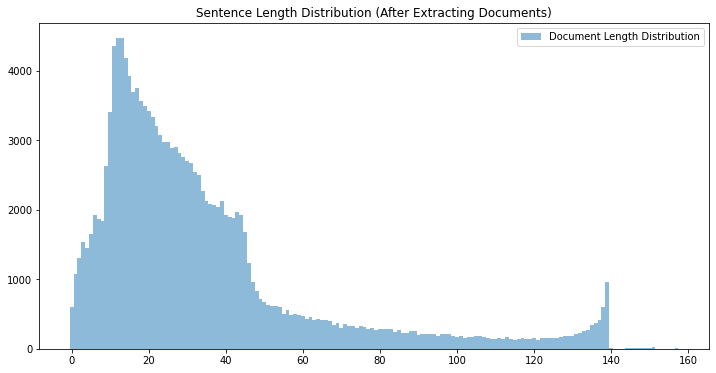

In [23]:
# 문장 길이 분포 시각화
sentence_length_distribution = np.zeros((max_len_no_tab), dtype=int)
for document in raw_documents:
    sentence_length_distribution[len(document) - 1] += 1

plt.figure(figsize=(12, 6))
plt.bar(range(max_len_no_tab), sentence_length_distribution, width=1.0, alpha=0.5, label='Document Length Distribution')
plt.title("Sentence Length Distribution (After Extracting Documents)")
plt.legend()
plt.show()

%matplotlib inline

- 길이 135~140 확인하여 MAX LENGTH 설정하자(그 이상은 이상치로)

In [24]:
# 길이가 136인 문서 찾기
check_document_with_length(raw_documents, 136)

Total number of documents with length 136: 339 

뮤지컬 영화인데 사운드 녹음 엉망, 남주는 춤도 못추고, 내용은 뻔할뻔, 주인공들 목소리도 너무 안어울리고 어제 CGV에서 뛰어 나가려다 참았습니다.진심 말리고 싶습니다. 영국의 저예산 DVD용 영화뮤지컬영화 아닙니다. 맘마미아 1/10도 안됨
이영화 구성좋다는분들 ㅋㅋ아마 친구랑 같이영화보고 님들이 영화 좋다고 재밌다하면 같이본 친구들은 이해하지 못할겁니다 ㅋㅋ진짜 최악 최저 스토리 주인공 행동 개연성없음캐릭간의 이해관계 최악 ㅋㅋㅋCIA갘ㅋㅋ이렇게 허접하게 표현된 영화 간만이라능ㅋ
독립영화 실력자들의 스타 리그, 옴니버스라는 피로감이 극복되는 수준이다. '얼음강'은 단독 장편으로 만들었어도 좋았을 듯. 주인공이 혹여 - 평소라면 1%도 공감 안되는 - 여호와의 증인이라도 납득이 될 정도로 감정을 설득하는 솜씨가 탁월하다.
감동이다.. 참고로 이 영화 보신분들 마지막엔딩부분에 자막으로나오는부분잇죠? .. 이게 영화상에서 실화라는거지 진짜 레알 현재 실제로 실화라는말이아니에요.. 전지현이 피디잔아요 다큐찍는거 ...그 다큐에서엔딩장면이지 진짜 실제가아니에여.. 쨋든
알 행님의 연기 쩔었음.특히 매니가 문을 열어주고 2층에서 여동생을본후 다시 매니를 쳐다볼때에그 분노에 찬 얼굴.잊혀지지가 않는다.이번이 이영화 3번째라는.계속봐도 질리지않는영화..알 형님의 카리스마가 대단한 영화였음그리고 리즈시절의 미쉘누님의


In [25]:
# 길이가 138인 문서 찾기
check_document_with_length(raw_documents, 138)

Total number of documents with length 138: 420 

하..진짜 댓글보고 한번쯤볼만한 영화인거같아서봤지만 기가찬다..이게무슨버킷리스트인가! 죽기직전에 소원들어주기? 내가보기엔 죽기직전에 막 살자 인거같다. 감동도없고.. 진짜 '버킷리스트' 란 영화에 발톱에 때만큼도 못따라가는쓰레기영화.. 완존실망..
짱이다ㅎ 혼자자식키우며살아온엄마 그의아들 힘들게살아오면서 서로예민해지고날카로워질때도잇엇지만 결국 ..가족ㅎ 아빠라는 사람도 생각보다최악이아니고..여자는, 확실히 요구하면도와준다는 그말이 왠지짠하게와닿는다ㅎ 나혼자괜히끙끙거리지말자ㅡ이런단순한생각이든다
평점이 너무 높군요. 원작으로 보심이 나을듯. 짧은 러닝타임에 감사하다고 해야하나. 주인공이 썰매를 타고 목적지에 가니 모든 사람들의 기억이 돌아온다는 황당한 설정이고 인간의 감정을 통제한다는건 데몰리션맨, 이퀄리브리엄에서 봤기때문에 신선함도 없음
한편의 영화에 너무도 많은걸 하려구 한거 같은데 결국 이것도 저것도 아닌 영화가 되버렸다. 뭔가 한가지 뛰어난게 없다 겜블영화도 아니고 갱영화도 아니구 형사물도 아니구 그냥 킬링타임용으로도 솔직히 별루다. 밴에플렉 펜이지만 좋은 점수를 줄수가 없다
쥬산과 데이는 샬로를 너무도 순수하고맹목적으로 사랑했지만 정작 샬로는 그들이 자신을 사랑하는만큼 그들을 사랑하지 않았고 자기 본능과 자기 살길에 더 충실했던 답답한 인간일 뿐이었다.덕분에 쥬산과 데이의 최후는 너무도 가슴을 아리고 먹먹하게 만든다.


In [26]:
# 길이가 140인 문서 찾기
check_document_with_length(raw_documents, 140)

Total number of documents with length 140: 964 

데너리스 타르 가르엔...나도 용의주인이 되고 싶다...누이랑,근친상간이나 하고 다닐지라도,소설 속에선 제일 멋진 놈이 자이메 라니스터였는데,드라마속에선,드래곤(용)이 제일 멋지네(웃음)감독님 토르-2 다크 월드는 말아 잡수셨을지라도,기본 선방은 했음
아~ 진짜 조금만 더 손 좀 보면 왠만한 상업 영화 못지 않게 퀄리티 쩔게 만들어 질 수 있었는데 아쉽네요 그래도 충분히 재미있었습니다 개인적으로 조금만 더 잔인하게 더 자극적으로 노출씬도 화끈하게 했더라면 어땠을까 하는 국산영화라 많이 아낀 듯 보임
평점조절위원회에서 나왔습니다(웃음)김혜선은 @내일이 오면@의 김순정,순정이 역할이 제일이다.팜므파탈로써,그 정도까지 잘해낼 줄은,정말 의외였어...연기20년 한사람에게 요즘 사극에서 벌어지고 있는,그녀에 대한 연기논란은 왠지 코미디의한장면 같음(웃음)
사실여부를 떠나,알고왔던 아더와 너무 매칭이 안돼더라.원탁기사중 실제 검술 최고수는 랜슬롯으로 알고 있는데,트리스탄보다 못하고,싸우는 검술은 마치 중국검술 흉내낸거 같은게;; 그리고 란슬롯이 실제는 쌍검였나?너무 매칭이 안대 하튼 ㅋ기네비어역도 미스.
진짜 이건 아님ㅋㅋㅋㅋㅋ액션영화좋아해서 액션영화만 다운받아서 꾸준히 본게 벌써 몇년인 사람임 근데 이건 진짴ㅋㅋㅋㅋㅋㅋ아무리 점수 잘 줘도 100점 만점에 10점?ㅡㅡ돈주고봤는데너무아깝다진짜ㅜㅜ그리고대체 왜 13구역 타이틀을 달고나왔는지 모르겠음 실망


In [27]:
# 길이가 138 141인 문서 찾기
check_document_with_length(raw_documents, 141)

Total number of documents with length 141: 6 

"""배경이 프랑스인 """"파리 5구의 여인""""도 망작이고. 미국이 배경인 빅픽처를 프랑스로 옮겨가서도 이런 졸작을 만들어 내다니. 원작자가 수많은 시나리오 각색을 물리고 이작품을 흡족해 했다는데. 영화를 보고 나서도 만족했을까? 최고의 망작"""
"""처음엔 """"오로라 공주"""" 제목두 상큼한 느낌이라 재밋을꺼 같았는데.. 마침표 찍을 쯤되면 이갸기 꾸며내구.. 끄니까 재미 없어요.. 언제 끝나는지두.. 100회 넘었어요.. 시누이 갈등 있고 설매니저랑 잘 되는줄 알았는데 또 끌구.."""
"""처음쓰는거라 뭐 부터 말을 해야할지 잘모르겠지만몇자 적어봅니다 태어나서 이런거 적는건처음인거같네요! 28년 살면서 눈물 펑펑흘린드라마 처음이네요.최고의 명대사☆이~애비 오늘은 늦지않았다 은중아""""드라마는 감독이 없나요?이름좀 알고싶은데.."""
"""'아빠어디가' 민국·지아, 애니 더빙 도전!더빙이 무슨 농촌체험이냐ㅡㅡ애들하고싶다하니까 경험으로 시켜줘야지하게 어엿히 극장에서 손님들이 """"돈을 내고"""" 보는 영상물인데 거기에 연기해본적도 없는 애들을 출연시켜? 허허 말같지도않아서.."""
"""내가 죽을때 남기고 싶은 유언:""""후손들에게 억만금의 재산을 물려주는것보다도 이 영화를 더 많은 사람에게 알려주는게 제일 중요하다""""백년이 지나도 천년이 지나도 원작가 톨킨과 피터잭슨 감독의 이름은 영원히 잊혀지지 않을것이라 생각된다."""


In [28]:
# 길이가 100인 문서 찾기
check_document_with_length(raw_documents, 110)

Total number of documents with length 110: 141 

이건 시종일관 질~~질왜? 제목이 야경꾼 일지냐고 지금 10회가 넘어가는데 즉 2달이 넘어가는데. 앞에서 누군가가 얘기 하더만 이거 100부작이냐고 그러다 또 한 순간에 모든걸 훅진짜 지루함의 지존
내 기준으로 볼때, 영화는 수작이라고 표현해도 과찬이 아니지만, 황제,황후 두사람의 불화로 인해 엄청난 수의 사람들이 죽어가는 고대사를 보면서 마음에 불편한점이 가시질 않았던 영화 영화자체는 명작.
연출력이나 그래픽 수준 보면 뭔 쌍팔년도 시대에 어떻게 스마트폰을 쓸수 있는걸까 하는 착각에 빠지는 경험을 하실수 있습니다. 꼭 보세요!는 개뿔 이거 볼바에 영구와 용가리 2탄을 보는게 낫겠다 ㅅ밤
한마디로 한편의 '결혼 앨범'.. 주인공들이 결혼하고.. 피로연하고.. 신혼 생활하고.. 그게 다였던듯.. 그냥 다음편을 궁금해서 보게 만들기위한 예고편을 길게 느러뜨려놓은 느낌.. 정말 지루함..
연기와 분장이 훌륭한 영화 였다. 영화 보다는 연극을 본 기분이 든다. 영화 자체의 완성도나 작품성은 별개로 설경구 라는 배우가 연기로 마음껏 발산하고 내뿜을수 있는 무대로 최적화 된 영화 같았다.


In [29]:
# 길이가 100인 문서 찾기
check_document_with_length(raw_documents, 100)

Total number of documents with length 100: 182 

평중 '나만 당할수 없다'가있었는데 꼭 맞는 영화이다.차라리 월트디즈니 애니메이션으로 만들었으면 나았을 뻔한실망만 안겨주는 영화 부도리의 꿈 이후로 이렇게 빡치는 영화는 처음이다.
소중한 사람들은 잃어가는 장면에서 김준식의 아픔을 절실하게 느꼈고, 전쟁은 아무런 의미없는 살육이라는 것과 절대로 일어나서는 안되는 것임을 이 영화를 통해 눈물로써 깨닫게 되었다.
네이키드 킬러(적나고양) - 네이키드 웨폰 을 잇는 여성 킬러 액션 제3탄. 시대가 흐르면 감각도 업그레이드가 되어야 하는 법. 어뜨케 쌍팔년도에 나온 홍콩액션물 반도 못따라가니?
허접한 극본과 강렬한 연출이 대비되는 작품.너무 허접하기 짝이 없는 극본 때문에 등장인물들이 연기를 잘해도 재미의 반감만 가득해질 뿐이다.차진수역에 박해준씨가 제일 기억에 남는다.
진짜진짜 보다보다 이렇게지겨운만화첨입니다딸램보여주려갔더만헉포스터사기입니다포스터색감이라도되면좋으려만시커한바다 우울한 대사더빙엉망임이렇게재미없을수있나요극장서 중간 애들이졸리다고난리ㅡㅡ


In [30]:
def count_range(start, end):
    count = 0
    for doc in raw_documents:
        length = len(str(doc))
        if start <= length <= end:
            count += 1
    return count  #HERE

In [31]:
print(count_range(105, 140))
print(100*(count_range(105, 140) / count_range(1, 158)),"\n")
print(count_range(136, 140))
print(100*(count_range(136, 140) / count_range(1, 158)))

7912
5.274842494749825 

2701
1.8007266908896962


In [32]:
print(count_range(1, 6))
print(100*(count_range(1, 6) / count_range(1, 158)),"\n")

7626
5.084169472315744 



#### 👁️👁️DATA REVIEW

- 길이 136 ~ 140 인 리뷰 퀄리티 좋지만, 전체 1%도 안됨.  
- => 고로, 106 이상 이상치로 간주하고 제거함
- =>        7 미만도 이상치로 설정 (7 미만은 주어가 없어 무엇이 좋았는지 확인 안됨)  

## 본격적인 전처리 : 결측값 및 중복, 이상치 제거

### 제거 전 확인

In [33]:
# 데이터 불러오기 전 시각화 (결측값, 중복 확인)
def visualize_data(file_path):
    data = pd.read_csv(file_path, sep='\t')
    
    # 결측값 및 중복 확인 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Counting Missing Value')
    data.isnull().sum().plot(kind='bar')
    
    plt.subplot(1, 2, 2)
    plt.title('Counting Duplication')
    duplicated_count = data.duplicated(subset=['document']).sum()
    plt.bar(['Duplication Sample'], [duplicated_count])
    plt.show()  #HERE

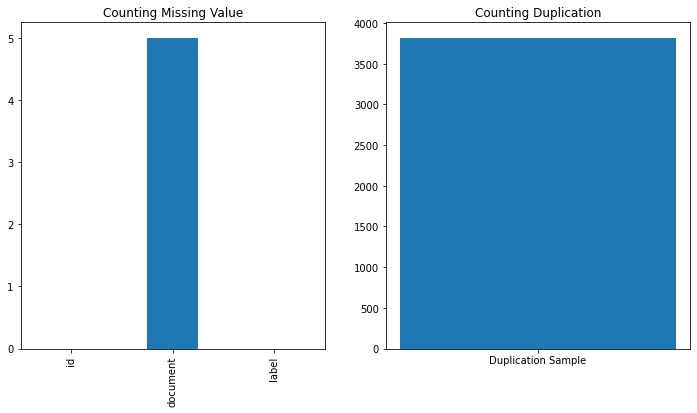

In [34]:
visualize_data(train_data_path)

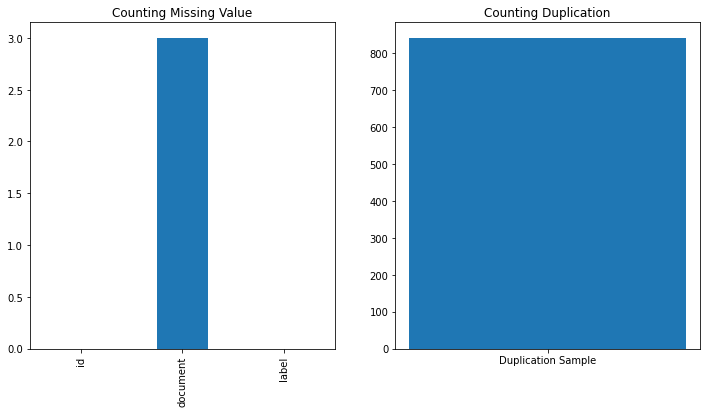

In [35]:
visualize_data(test_data_path)

### 제거 실행

In [36]:
def load_data(file_path):
    data = pd.read_csv(file_path, sep='\t')
    # 결측값 및 중복 제거
    data = data.dropna(how='any')  # 결측값 제거
    data = data.drop_duplicates(subset=['document'])  # 중복 제거
    
    # 이상치 제거 (길이 7 미만, 106 이상인 데이터 제거)
    data['length'] = data['document'].apply(lambda x: len(str(x)))
    data = data[(data['length'] >= 7) & (data['length'] <= 106)]
    
    return data  #HERE

In [37]:
train_data = load_data(train_data_path)
test_data = load_data(test_data_path)
print(f"훈련 데이터: {len(train_data)}개, 테스트 데이터: {len(test_data)}개")

훈련 데이터: 133855개, 테스트 데이터: 44836개


---

# Step 03: SentencePiece 모델 학습 및 Tokenizer 구현

---

In [38]:
# 코퍼스 추출
corpus = train_data['document'].tolist()
# 토크나이저의 어휘 사전 크기 설정
vocab_size = 8000
# 코퍼시 저정할 임시 파일 경로
temp_file = train_data_path

In [39]:
# 임시 파일에 코퍼스 저장(SentencePiece 모델 학습을 위한 텍스트 파일을 준비)

# temp_file 경로에 파일을 열고 쓰기 모드('w')로 파일 객체 f를 만듦
with open(temp_file, 'w') as f: 
    for row in corpus:
        f.write(str(row) + '\n')

### 본격 SentencePiece 모델 학습 및 Tokenizer 구현

In [40]:
# SentencePiece 모델 학습
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)
)

# SentencePiece 모델 로드 및 토크나이징 함수 정의
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

def sp_tokenize(s, corpus):
    tensor = []
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({word: idx})
        index_word.update({idx: word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

# 훈련 데이터 토큰화
tensor_train, word_index, index_word = sp_tokenize(s, train_data['document'])

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/ratings_train.txt --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/ratings_train.txt
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pa

---

# Step 04: 네이버 영화리뷰 감정 분석 모델 학습

---

In [41]:
# 레이블 준비
y_train = train_data['label'].values

# 데이터셋 분할(훈련,검증 나누기)
tensor_train, X_val, y_train, y_val = train_test_split(tensor_train, y_train, test_size=0.2, random_state=42)

In [42]:
# 모델 정의 및 학습
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(tensor_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

Epoch 1/5
1674/1674 [==============================] - 460s 272ms/step - loss: 0.3859 - accuracy: 0.8256 - val_loss: 0.3306 - val_accuracy: 0.8580
Epoch 2/5
1674/1674 [==============================] - 453s 271ms/step - loss: 0.2962 - accuracy: 0.8714 - val_loss: 0.3208 - val_accuracy: 0.8625
Epoch 3/5
1674/1674 [==============================] - 451s 269ms/step - loss: 0.2521 - accuracy: 0.8915 - val_loss: 0.3430 - val_accuracy: 0.8598
Epoch 4/5
1674/1674 [==============================] - 454s 271ms/step - loss: 0.2128 - accuracy: 0.9101 - val_loss: 0.3562 - val_accuracy: 0.8568
Epoch 5/5
1674/1674 [==============================] - 455s 272ms/step - loss: 0.1705 - accuracy: 0.9301 - val_loss: 0.4182 - val_accuracy: 0.8543


In [43]:
# 테스트 데이터 토큰화 및 평가
tensor_test, _, _ = sp_tokenize(s, test_data['document'])
y_test = test_data['label'].values

test_loss, test_acc = model.evaluate(tensor_test, y_test)
print(f"sp_tokenize 테스트 정확도: {test_acc * 100:.2f}%")

1402/1402 [==============================] - 79s 56ms/step - loss: 0.4216 - accuracy: 0.8470
sp_tokenize 테스트 정확도: 84.70%


**결과 :**

# Step 5: KoNLPy 형태소 분석기와의 성능 비교 
## (Mecab, Kkma, Okt)

### KoNLPy 전용 토큰화 함수 (analyzeObj = Mecab, Kkma, Okt)

In [44]:
def tokenize_with_konlpy(analyzeObj, corpusList):
    tokenized_corpus = []  #HERE
    for sentence in corpusList:
        tokenized_corpus.append(analyzeObj.morphs(sentence))
    return tokenized_corpus

In [47]:
# Mecab, Kkma, Okt Tokenizers
mecab = Mecab()
# okt = Okt()
# kkma = Kkma()

# 각 형태소 분석기를 사용하여 코퍼스 토큰화
tokenized_mecab = tokenize_with_konlpy(mecab, corpus)
tokenized_mecab_test = tokenize_with_konlpy(mecab, test_data['document'])

#tokenized_okt = tokenize_with_konlpy(okt, corpus)
#tokenized_okt_test = tokenize_with_konlpy(okt, test_data['document'])

# tokenized_kkma = tokenize_with_konlpy(kkma, corpus)
# tokenized_kkma_test = tokenize_with_konlpy(kkma, test_data['document'])

### Mecab : Tensor 변환 및 모델 평가

Mecab

In [48]:
# 토큰화된 결과를 사용하여 Tensor 변환 및 모델 평가 (Mecab 예시)
tensor_mecab = tf.keras.preprocessing.sequence.pad_sequences(
    [[word_index.get(word, 0) for word in sentence] for sentence in tokenized_mecab], padding='pre'
)

y_train_mecab = train_data['label'].values
tensor_train_mecab, X_val_mecab, y_train_mecab, y_val_mecab = train_test_split(tensor_mecab, y_train_mecab, test_size=0.2, random_state=42)

model.fit(tensor_train_mecab, y_train_mecab, validation_data=(X_val_mecab, y_val_mecab), epochs=5, batch_size=64)


Epoch 1/5
1674/1674 [==============================] - 431s 256ms/step - loss: 0.3641 - accuracy: 0.8311 - val_loss: 0.3602 - val_accuracy: 0.8341
Epoch 2/5
1674/1674 [==============================] - 428s 255ms/step - loss: 0.3213 - accuracy: 0.8542 - val_loss: 0.3526 - val_accuracy: 0.8405
Epoch 3/5
1674/1674 [==============================] - 422s 252ms/step - loss: 0.2968 - accuracy: 0.8663 - val_loss: 0.3594 - val_accuracy: 0.8408
Epoch 4/5
1674/1674 [==============================] - 425s 254ms/step - loss: 0.2739 - accuracy: 0.8792 - val_loss: 0.3728 - val_accuracy: 0.8402
Epoch 5/5
1674/1674 [==============================] - 425s 254ms/step - loss: 0.2520 - accuracy: 0.8889 - val_loss: 0.3820 - val_accuracy: 0.8376


In [49]:
# 테스트 데이터 평가 (Mecab 예시)
tensor_test_mecab = tf.keras.preprocessing.sequence.pad_sequences(
    [[word_index.get(word, 0) for word in sentence] for sentence in tokenized_mecab_test], padding='pre'
)

test_loss_mecab, test_acc_mecab = model.evaluate(tensor_test_mecab, y_test)
print(f"Mecab 토크나이저 테스트 정확도: {test_acc_mecab * 100:.2f}%")

1402/1402 [==============================] - 65s 47ms/step - loss: 0.5863 - accuracy: 0.5913
Mecab 토크나이저 테스트 정확도: 59.13%


## 토크나이저 성능비교 : SentencePiece vs. Mecab 

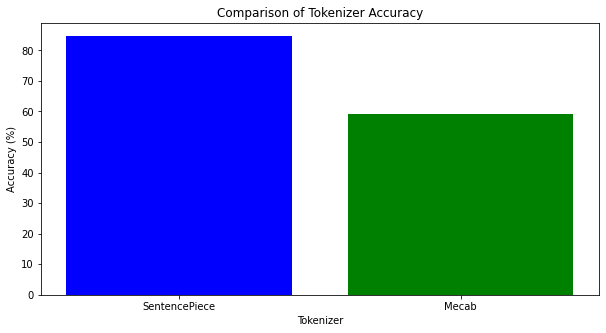

In [50]:
# 정확도 비교
plt.figure(figsize=(10, 5))
plt.bar(['SentencePiece', 'Mecab'], [test_acc * 100, test_acc_mecab * 100], color=['blue', 'green'])
plt.xlabel('Tokenizer')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Tokenizer Accuracy')
plt.show()